Bonjour, 

Merci pour ton aide sur ce projet !

Ta mission est de réaliser, dans une première itération, une étude de faisabilité d'un moteur de classification d'articles, basé sur une image et une description, pour l'automatisation de l'attribution de la catégorie de l'article.

Tu dois analyser les descriptions textuelles et les images des produits, au travers des étapes suivantes : 

Un prétraitement des données texte ou image suivant le cas ;
Une extraction de features ;
Une réduction en 2 dimensions, afin de projeter les produits sur un graphique 2D, sous la forme de points dont la couleur correspondra à la catégorie réelle ;
Analyse du graphique afin d’en déduire ou pas, à l’aide des descriptions ou des images, la faisabilité de regrouper automatiquement des produits de même catégorie ;
Réalisation d’une mesure pour confirmer ton analyse visuelle, en calculant la similarité entre les catégories réelles et les catégories issues d’une segmentation en clusters.
Pourrais-tu nous démontrer, par cette approche, la faisabilité de regrouper automatiquement des produits de même catégorie ?

Voici les contraintes : 

Afin d’extraire les features texte, il sera nécessaire de mettre en œuvre : 
- deux approches de type “bag-of-words” ;
- comptage simple de mots et Tf-idf ;
- une approche de type word/sentence embedding classique avec Word2Vec (ou Glove ou FastText) ;
- une approche de type word/sentence embedding avec BERT ;
- une approche de type word/sentence embedding avec USE (Universal Sentence Encoder). 

En pièce jointe, tu trouveras un exemple de mise en œuvre de ces approches d’extraction de features texte sur un autre dataset. Je t’invite à l’utiliser comme point de départ, cela va te faire gagner beaucoup de temps !

Afin d’extraire les features image, il sera nécessaire de mettre en œuvre :
un algorithme de type SIFT / ORB / SURF ;
un algorithme de type CNN Transfer Learning.
Concernant l’approche de type SIFT, je t’invite à regarder le webinaire que nous avons réalisé, disponible dans les ressources.

En pièces jointes, tu trouveras un exemple de mise en œuvre de l’approche de type CNN Transfer Learning d’extraction de features images sur un autre dataset. Je t’invite à l’utiliser comme point de départ, cela va te faire gagner beaucoup de temps !

Merci encore, 

Linda

PS : J’ai bien vérifié qu’il n’y avait aucune contrainte de propriété intellectuelle sur les données et les images.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import time

%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob
"""
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical"""

'\nimport tensorflow as tf\nfrom tensorflow.keras.models import Model, Sequential\nfrom tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout \nfrom tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom\nfrom tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint\nfrom tensorflow.keras.applications.vgg16 import VGG16\nfrom tensorflow.keras.applications.vgg16 import preprocess_input\nfrom tensorflow.keras.preprocessing.image import load_img, img_to_array\nfrom tensorflow.keras.utils import to_categorical'

In [2]:
df = pd.read_csv('Source/flipkart_com-ecommerce_sample_1050.csv',sep=',')

In [3]:
path_img = 'Source/Images'

In [4]:
df

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ..."
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ..."
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ..."
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-medium-viny...,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >.

In [5]:
df.dtypes

uniq_id                     object
crawl_timestamp             object
product_url                 object
product_name                object
product_category_tree       object
pid                         object
retail_price               float64
discounted_price           float64
image                       object
is_FK_Advantage_product       bool
description                 object
product_rating              object
overall_rating              object
brand                       object
product_specifications      object
dtype: object

In [6]:
df.isna().mean()

uniq_id                    0.000000
crawl_timestamp            0.000000
product_url                0.000000
product_name               0.000000
product_category_tree      0.000000
pid                        0.000000
retail_price               0.000952
discounted_price           0.000952
image                      0.000000
is_FK_Advantage_product    0.000000
description                0.000000
product_rating             0.000000
overall_rating             0.000000
brand                      0.321905
product_specifications     0.000952
dtype: float64

<AxesSubplot:>

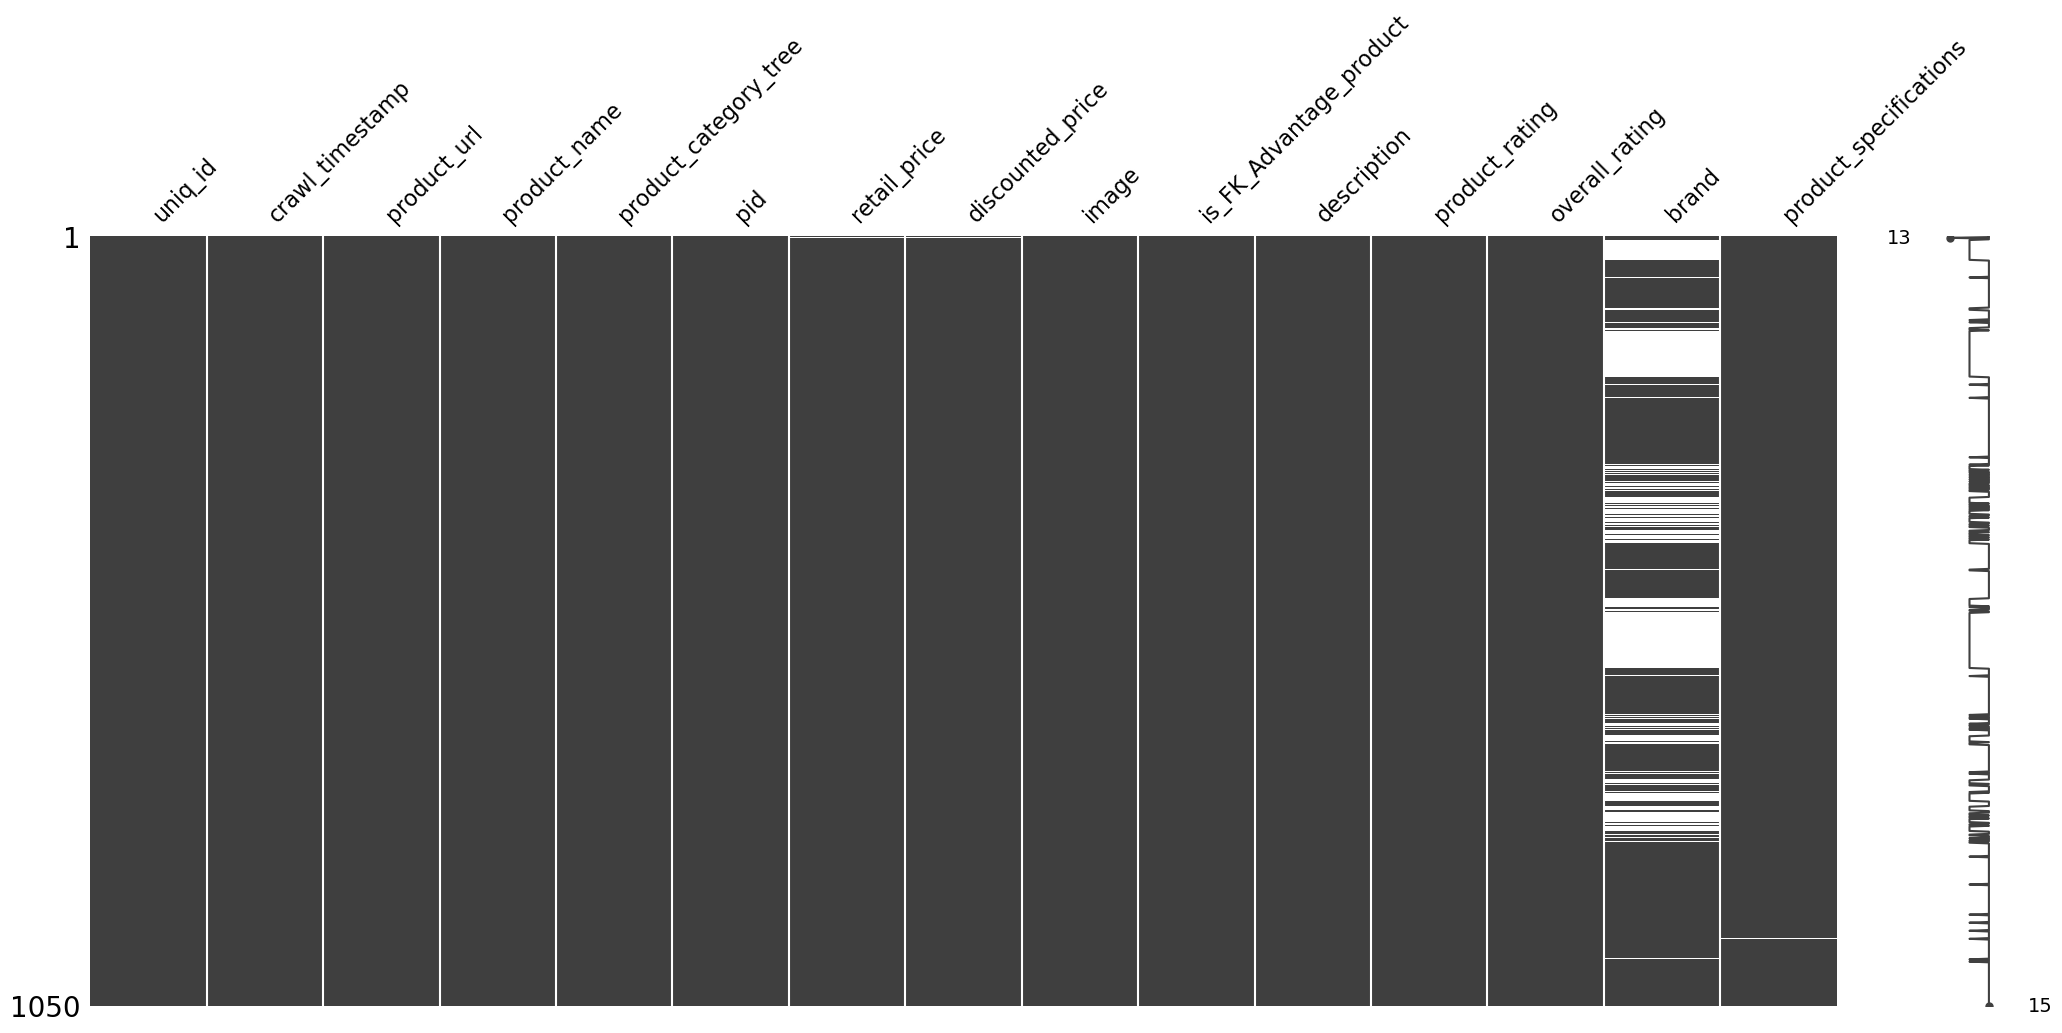

In [7]:
msno.matrix(df)

In [8]:
img = [img for img in df.image]
img_path = []

for i in range(len(img)):
    img_path.append(path_img+"/"+img[i])
    df['path_img'] = path_img+"/"+img[i]

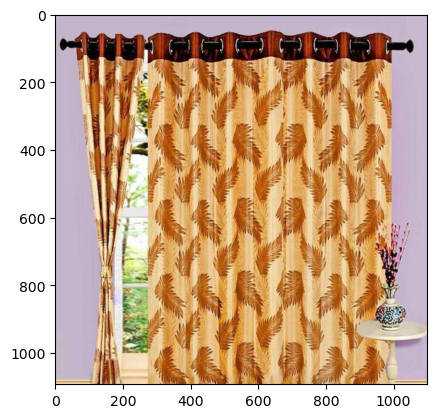

In [9]:
from matplotlib.image import imread

image = imread(img_path[1022])
plt.imshow(image)

In [10]:
df

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,path_img
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Source/Images/f2f027ad6a6df617c9f125173da71e44...
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Source/Images/f2f027ad6a6df617c9f125173da71e44...
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Source/Images/f2f027ad6a6df617c9f125173da71e44...
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Source/Images/f2f027ad6a6df617c9f125173da71e44...
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Source/Images/f2f027ad6a6df617c9f125173da71e44...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ...",Source/Images/f2f027ad6a6df617c9f125173da71e44...
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ...",Source/Images/f2f027ad6a6df617c9f125173da71e44...
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,Fa

In [11]:
# affiche l'url pour visionner l'image du produit

df.product_url[0]

'http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z'

In [12]:
df.product_url[1]

'http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH'

### Note

- livré le notebook 1 et 2 
- premier notebook NLP 40 % 
- première partie : nettoyage 
- deux parties : texte (données non structurées) 
- deuxième notebook image 40 %

##### Partie nettoyage 

- voir librairie NLTK 
- couper les phrases => tokeniser les mots (compter les mots par phrases)
- bascule d'une liste de texte à une matrice 
- mettre le texte en miniscule 
- enlever la ponctuation 
- bag of word 50 % de partie du NLP
- première approche calculer des fréquences de mots 
- matrice de confusion (cross_tabulation)

In [13]:
# premier notebook NLP 40 % 
# deux parties : texte (données non structurées)
# deuxième notebook image 40 % 

cols = ['product_name',
        'product_category_tree',
        'description',
        'brand']

df_texte = df.loc[:,cols]
df_texte

,product_name,product_category_tree,description,brand
0,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",Key Features of Elegance Polyester Multicolor ...,Elegance
1,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Specifications of Sathiyas Cotton Bath Towel (...,Sathiyas
2,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Key Features of Eurospa Cotton Terry Face Towe...,Eurospa
3,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of SANTOSH ROYAL FASHION Cotton P...,SANTOSH ROYAL FASHION
4,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of Jaipur Print Cotton Floral Kin...,Jaipur Print
...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Oren Empower Extra Large Self Adhesive Sticker...,Oren Empower
1046,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Wallmantra Large Vinyl Sticker Sticker (Pack o...,Wallmantra
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,Uberlyfe
1048,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Buy Wallmantra Medium Vinyl Sticker Sticker fo...,Wallmantra


In [14]:
# extraire la première catégorie exemple 'Kitchen & Dining' et la deuxième catégorie 
# analyse les fréquences de la target 
# 
token = np.array(df_texte.product_category_tree)
token

array(['["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]',
       '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]',
       '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]',
       ...,
       '["Baby Care >> Baby & Kids Gifts >> Stickers >> Uberlyfe Stickers"]',
       '["Baby Care >> Baby & Kids Gifts >> Stickers >> Wallmantra Stickers"]',
       '["Baby Care >> Baby & Kids Gifts >> Stickers >> Uberlyfe Stickers"]'],
      dtype=object)

### 1.1 Pretraitement des données textes et images


Voici les contraintes : 

Afin d’extraire les features texte, il sera nécessaire de mettre en œuvre : 
- deux approches de type “bag-of-words”, comptage simple de mots et Tf-idf ;
- une approche de type word/sentence embedding classique avec Word2Vec (ou Glove ou FastText) ;
- une approche de type word/sentence embedding avec BERT ;
- une approche de type word/sentence embedding avec USE (Universal Sentence Encoder). 

In [15]:
len(token)

1050

In [16]:
# lire des caractère sur une image
import nltk

In [17]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dragomir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
tokenizer = nltk.RegexpTokenizer(r'\w+')

In [19]:
token = [tokenizer.tokenize(i.lower()) for i in token]

In [20]:
token

[['home',
  'furnishing',
  'curtains',
  'accessories',
  'curtains',
  'elegance',
  'polyester',
  'multicolor',
  'abstract',
  'eyelet',
  'do'],
 ['baby',
  'care',
  'baby',
  'bath',
  'skin',
  'baby',
  'bath',
  'towels',
  'sathiyas',
  'baby',
  'bath',
  'towels',
  'sathiyas',
  'cotton',
  'bath',
  'towel',
  '3',
  'bath',
  'towel',
  'red',
  'y'],
 ['baby',
  'care',
  'baby',
  'bath',
  'skin',
  'baby',
  'bath',
  'towels',
  'eurospa',
  'baby',
  'bath',
  'towels',
  'eurospa',
  'cotton',
  'terry',
  'face',
  'towel',
  'set',
  '20',
  'piece',
  'fa'],
 ['home',
  'furnishing',
  'bed',
  'linen',
  'bedsheets',
  'santosh',
  'royal',
  'fashion',
  'bedsheets',
  'santosh',
  'royal',
  'fashion',
  'cotton',
  'printed',
  'king',
  'sized'],
 ['home',
  'furnishing',
  'bed',
  'linen',
  'bedsheets',
  'jaipur',
  'print',
  'bedsheets',
  'jaipur',
  'print',
  'cotton',
  'floral',
  'king',
  'sized',
  'double',
  'bed'],
 ['watches', 'wrist', 

In [21]:
bigram = [list(nltk.bigrams(bigram)) for bigram in token]

In [22]:
bigram[0][0]

('home', 'furnishing')

In [23]:
token_bigram = pd.Series(bigram)
token_bigram

0       [(home, furnishing), (furnishing, curtains), (...
1       [(baby, care), (care, baby), (baby, bath), (ba...
2       [(baby, care), (care, baby), (baby, bath), (ba...
3       [(home, furnishing), (furnishing, bed), (bed, ...
4       [(home, furnishing), (furnishing, bed), (bed, ...
                              ...                        
1045    [(baby, care), (care, baby), (baby, kids), (ki...
1046    [(baby, care), (care, baby), (baby, kids), (ki...
1047    [(baby, care), (care, baby), (baby, kids), (ki...
1048    [(baby, care), (care, baby), (baby, kids), (ki...
1049    [(baby, care), (care, baby), (baby, kids), (ki...
Length: 1050, dtype: object

In [24]:
cat_name = np.array([token_bigram[i][0] for i in range(len(token_bigram))])

In [25]:
cat_name[:10]

array([['home', 'furnishing'],
       ['baby', 'care'],
       ['baby', 'care'],
       ['home', 'furnishing'],
       ['home', 'furnishing'],
       ['watches', 'wrist'],
       ['watches', 'wrist'],
       ['watches', 'wrist'],
       ['watches', 'wrist'],
       ['watches', 'wrist']], dtype='<U10')

In [88]:
df_token = pd.DataFrame(cat_name, columns=['cat1','cat2'])
df_token = df_token.cat1 + ' ' +  df_token.cat2

In [89]:
df_token

0       home furnishing
1             baby care
2             baby care
3       home furnishing
4       home furnishing
             ...       
1045          baby care
1046          baby care
1047          baby care
1048          baby care
1049          baby care
Length: 1050, dtype: object

In [28]:
df_token = pd.DataFrame(cat_name, columns=['cat1','cat2'])
df_token = df_token.cat1
df_token.unique()

array(['home', 'baby', 'watches', 'kitchen', 'beauty', 'computers'],
      dtype=object)

In [90]:
df_texte['category_name'] = df_token

In [91]:
freq_cat = nltk.FreqDist(df_token)
freq_cat

FreqDist({'home furnishing': 150, 'baby care': 150, 'home decor': 150, 'kitchen dining': 150, 'beauty and': 150, 'watches wrist': 149, 'computers laptop': 87, 'computers network': 49, 'computers computer': 6, 'computers tablet': 3, ...})

In [92]:
freq_cat = pd.Series(freq_cat)


In [93]:
df_freq = pd.DataFrame({'valeur': freq_cat.values}, index=freq_cat.index)


<AxesSubplot:>

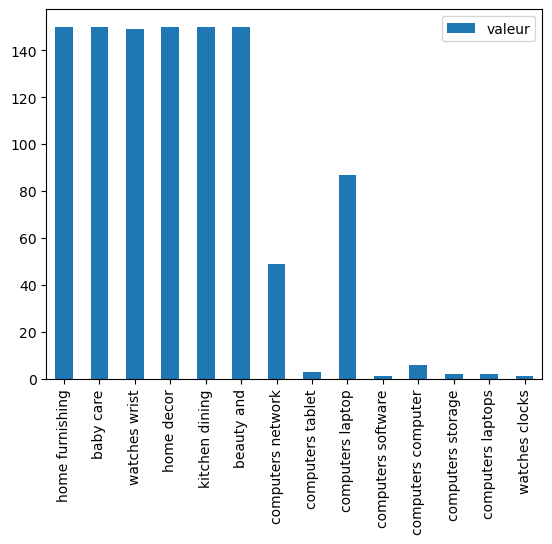

In [94]:
df_freq.plot(y = 'valeur', kind = 'bar')

In [95]:
df_texte.loc[df_texte.category_name == 'computers laptops','category_name'] = 'computers laptop'

In [96]:
df_texte

,product_name,product_category_tree,description,brand,category_name,label_cat1
0,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",Key Features of Elegance Polyester Multicolor ...,Elegance,home furnishing,3
1,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Specifications of Sathiyas Cotton Bath Towel (...,Sathiyas,baby care,0
2,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Key Features of Eurospa Cotton Terry Face Towe...,Eurospa,baby care,0
3,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of SANTOSH ROYAL FASHION Cotton P...,SANTOSH ROYAL FASHION,home furnishing,3
4,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of Jaipur Print Cotton Floral Kin...,Jaipur Print,home furnishing,3
...,...,...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Oren Empower Extra Large Self Adhesive Sticker...,Oren Empower,baby care,0
1046,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Wallmantra Large Vinyl Sticker Sticker (Pack o...,Wallmantra,baby care,0
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,Uberlyfe,baby care,0
1048,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Buy Wallmantra Medium Vinyl Sticker Sticker fo...,Wallmantra,baby care,0


### Méthode tf-idf

In [97]:
df_texte.description[0]

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

In [98]:
token2 = np.array(df_texte.description)
token2 = [tokenizer.tokenize(i.lower()) for i in token2]

In [99]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dragomir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [100]:
sw = set()
sw.update(tuple(nltk.corpus.stopwords.words('english')))

In [101]:
# récupère unqiuement les mots importants

descript_sw = [[idx for idx in token if idx not in sw] for token in token2]

In [102]:
freq_desc = [nltk.FreqDist(i) for i in descript_sw]

In [103]:
df_texte.category_name.value_counts()

home furnishing       150
baby care             150
home decor            150
kitchen dining        150
beauty and            150
watches wrist         149
computers laptop       89
computers network      49
computers computer      6
computers tablet        3
computers storage       2
computers software      1
watches clocks          1
Name: category_name, dtype: int64

In [104]:
# analyse des mots les plus férquents pour la cat home furnishing

home_furnishing_idx = df_texte.loc[df_texte.category_name == 'home furnishing',:].index
home_furnishing_idx

baby_care_idx = df_texte.loc[df_texte.category_name == 'baby care',:].index
baby_care_idx

home_decor_idx = df_texte.loc[df_texte.category_name == 'home decor',:].index
home_decor_idx

kitchen_dining_idx = df_texte.loc[df_texte.category_name == 'kitchen dining',:].index
kitchen_dining_idx

beauty_and_idx = df_texte.loc[df_texte.category_name == 'beauty and',:].index
beauty_and_idx

watches_wrist_idx = df_texte.loc[df_texte.category_name == 'watches wrist',:].index
watches_wrist_idx

computers_laptop_idx = df_texte.loc[df_texte.category_name == 'computers laptop',:].index
computers_laptop_idx

computers_network_idx = df_texte.loc[df_texte.category_name == 'computers network',:].index
computers_network_idx

computers_computer_idx = df_texte.loc[df_texte.category_name == 'computers computer',:].index
computers_computer_idx

computers_tablet_idx = df_texte.loc[df_texte.category_name == 'computers tablet',:].index
computers_tablet_idx

computers_storage_idx = df_texte.loc[df_texte.category_name == 'computers storage',:].index
computers_storage_idx

computers_software_idx = df_texte.loc[df_texte.category_name == 'computers software',:].index
computers_software_idx


Int64Index([87], dtype='int64')

In [105]:
corpus_home = [' '.join(descript_sw[idx]) for idx in home_furnishing_idx]
corpus_baby = [' '.join(descript_sw[idx]) for idx in baby_care_idx]
corpus_home_decor = [' '.join(descript_sw[idx]) for idx in home_decor_idx]
corpus_kitchen_dining = [' '.join(descript_sw[idx]) for idx in kitchen_dining_idx]
corpus_beauty = [' '.join(descript_sw[idx]) for idx in beauty_and_idx]
corpus_watches = [' '.join(descript_sw[idx]) for idx in watches_wrist_idx]
corpus_computers_laptop = [' '.join(descript_sw[idx]) for idx in computers_laptop_idx]
corpus_computers_network = [' '.join(descript_sw[idx]) for idx in computers_network_idx]
corpus_computers_computer = [' '.join(descript_sw[idx]) for idx in computers_computer_idx]
corpus_computers_tablet = [' '.join(descript_sw[idx]) for idx in computers_tablet_idx]
corpus_computers_storage = [' '.join(descript_sw[idx]) for idx in computers_storage_idx]
corpus_computers_software = [' '.join(descript_sw[idx]) for idx in computers_software_idx]

In [106]:
tok_home = tokenizer.tokenize(str(corpus_home))
tok_baby = tokenizer.tokenize(str(corpus_baby))
tok_home_decor = tokenizer.tokenize(str(corpus_home_decor))
tok_kitchen_dining = tokenizer.tokenize(str(corpus_kitchen_dining))
tok_beauty = tokenizer.tokenize(str(corpus_beauty))
tok_watches = tokenizer.tokenize(str(corpus_watches))
tok_computers_laptop = tokenizer.tokenize(str(corpus_computers_laptop))
tok_computers_network = tokenizer.tokenize(str(corpus_computers_network))
tok_computers_computer = tokenizer.tokenize(str(corpus_computers_computer))
tok_computers_tablet = tokenizer.tokenize(str(corpus_computers_tablet))
tok_computers_storage = tokenizer.tokenize(str(corpus_computers_storage))
tok_computers_software = tokenizer.tokenize(str(corpus_computers_software))

In [107]:
# mots les plus fréquents de la catégorie home furninsh

freq_totale = nltk.Counter()

freq_totale.update(tok_home)

freq_totale.most_common(100)[:20]

[('cm', 188),
 ('rs', 128),
 ('cotton', 103),
 ('pack', 88),
 ('cover', 84),
 ('products', 77),
 ('buy', 77),
 ('design', 76),
 ('free', 76),
 ('flipkart', 74),
 ('com', 74),
 ('genuine', 74),
 ('shipping', 74),
 ('cash', 74),
 ('delivery', 74),
 ('package', 63),
 ('1', 63),
 ('sales', 62),
 ('polyester', 61),
 ('color', 61)]

In [108]:
# mots les plus fréquents de la catégorie baby care

freq_totale = nltk.Counter()

freq_totale.update(tok_baby)

freq_totale.most_common(100)[:10]

[('baby', 316),
 ('cotton', 191),
 ('details', 174),
 ('girl', 165),
 ('fabric', 164),
 ('1', 140),
 ('dress', 105),
 ('specifications', 100),
 ('ideal', 98),
 ('general', 96)]

In [109]:
# mots les plus fréquents de la catégorie home décor

freq_totale = nltk.Counter()

freq_totale.update(tok_home_decor)

freq_totale.most_common(100)[:50]

[('cm', 282),
 ('showpiece', 204),
 ('rs', 140),
 ('1', 122),
 ('products', 90),
 ('best', 87),
 ('30', 84),
 ('free', 83),
 ('buy', 82),
 ('day', 81),
 ('online', 78),
 ('prices', 78),
 ('delivery', 77),
 ('shipping', 76),
 ('cash', 76),
 ('genuine', 76),
 ('replacement', 76),
 ('guarantee', 76),
 ('home', 75),
 ('inch', 74),
 ('wall', 74),
 ('price', 68),
 ('color', 67),
 ('5', 67),
 ('brass', 63),
 ('features', 61),
 ('number', 57),
 ('material', 51),
 ('box', 51),
 ('beautiful', 48),
 ('art', 48),
 ('package', 47),
 ('dimensions', 47),
 ('model', 44),
 ('made', 43),
 ('sales', 43),
 ('room', 42),
 ('width', 42),
 ('paper', 42),
 ('key', 41),
 ('product', 40),
 ('pack', 40),
 ('height', 40),
 ('type', 40),
 ('wooden', 39),
 ('specifications', 37),
 ('x', 37),
 ('ganesha', 36),
 ('gift', 36),
 ('6', 35)]

In [110]:
# mots les plus fréquents de la catégorie kitchen dining

freq_totale = nltk.Counter()

freq_totale.update(tok_kitchen_dining)

freq_totale.most_common(100)[:50]

[('mug', 323),
 ('ceramic', 206),
 ('coffee', 161),
 ('perfect', 143),
 ('5', 139),
 ('rs', 139),
 ('mugs', 130),
 ('material', 119),
 ('1', 100),
 ('day', 97),
 ('features', 92),
 ('design', 89),
 ('ml', 88),
 ('price', 88),
 ('gift', 87),
 ('specifications', 84),
 ('safe', 81),
 ('l', 78),
 ('quality', 72),
 ('loved', 72),
 ('pack', 70),
 ('products', 68),
 ('give', 68),
 ('3', 66),
 ('4', 65),
 ('best', 65),
 ('rockmantra', 65),
 ('product', 62),
 ('kitchen', 58),
 ('free', 58),
 ('microwave', 57),
 ('buy', 57),
 ('one', 57),
 ('tea', 56),
 ('fresh', 55),
 ('pizza', 54),
 ('prices', 53),
 ('dishwasher', 52),
 ('type', 52),
 ('steel', 51),
 ('water', 51),
 ('color', 51),
 ('also', 51),
 ('shipping', 51),
 ('cash', 51),
 ('delivery', 51),
 ('genuine', 51),
 ('replacement', 51),
 ('30', 50),
 ('guarantee', 50)]

In [111]:
# mots les plus fréquents de la catégorie beauty

freq_totale = nltk.Counter()

freq_totale.update(tok_beauty)

freq_totale.most_common(100)[:50]

[('flipkart', 163),
 ('com', 159),
 ('rs', 131),
 ('products', 128),
 ('set', 112),
 ('free', 110),
 ('30', 108),
 ('combo', 107),
 ('replacement', 105),
 ('delivery', 103),
 ('buy', 101),
 ('shipping', 101),
 ('cash', 101),
 ('genuine', 101),
 ('day', 101),
 ('guarantee', 101),
 ('online', 83),
 ('skin', 69),
 ('hair', 52),
 ('1', 51),
 ('box', 49),
 ('type', 44),
 ('traits', 42),
 ('color', 41),
 ('specifications', 40),
 ('prices', 38),
 ('oil', 37),
 ('body', 35),
 ('jewellery', 34),
 ('price', 34),
 ('3', 30),
 ('pack', 30),
 ('product', 29),
 ('ideal', 28),
 ('ml', 28),
 ('features', 27),
 ('cream', 27),
 ('soap', 27),
 ('care', 26),
 ('e', 26),
 ('general', 25),
 ('best', 25),
 ('lip', 25),
 ('kit', 24),
 ('beauty', 24),
 ('warranty', 23),
 ('soft', 23),
 ('oxyglow', 23),
 ('women', 22),
 ('material', 22)]

In [112]:
# mots les plus fréquents de la catégorie computers computer

freq_totale = nltk.Counter()

freq_totale.update(tok_computers_computer)

freq_totale.most_common(100)[:10]

[('warranty', 26),
 ('2', 14),
 ('memory', 14),
 ('type', 12),
 ('1', 9),
 ('features', 9),
 ('covered', 9),
 ('ddr2', 7),
 ('brand', 6),
 ('gb', 6)]

In [113]:
# mots les plus fréquents de la catégorie computers laptop

freq_totale = nltk.Counter()

freq_totale.update(tok_computers_laptop)

freq_totale.most_common(100)[:10]

[('laptop', 214),
 ('usb', 160),
 ('warranty', 124),
 ('replacement', 122),
 ('adapter', 116),
 ('battery', 106),
 ('power', 96),
 ('rs', 83),
 ('quality', 83),
 ('skin', 72)]

In [114]:
# mots les plus fréquents de la catégorie computers network

freq_totale = nltk.Counter()

freq_totale.update(tok_computers_network)

freq_totale.most_common(100)[:50]

[('buy', 48),
 ('rs', 48),
 ('flipkart', 48),
 ('com', 48),
 ('genuine', 48),
 ('products', 48),
 ('30', 48),
 ('day', 48),
 ('replacement', 48),
 ('guarantee', 48),
 ('free', 48),
 ('shipping', 48),
 ('cash', 48),
 ('delivery', 48),
 ('wireless', 16),
 ('router', 16),
 ('link', 10),
 ('0', 10),
 ('tenda', 7),
 ('dsl', 6),
 ('asus', 6),
 ('dual', 6),
 ('band', 6),
 ('modem', 5),
 ('extender', 5),
 ('range', 5),
 ('wi', 5),
 ('fi', 5),
 ('trendnet', 5),
 ('edimax', 5),
 ('300', 4),
 ('warranty', 4),
 ('operating', 4),
 ('4', 4),
 ('n', 4),
 ('n300', 4),
 ('tp', 4),
 ('netgear', 4),
 ('dap1320', 3),
 ('speed', 3),
 ('mbps', 3),
 ('c', 3),
 ('gigabit', 3),
 ('zyxel', 3),
 ('port', 3),
 ('features', 2),
 ('white', 2),
 ('type', 2),
 ('covered', 2),
 ('damage', 2)]

In [115]:
# mots les plus fréquents de la catégorie computers software

freq_totale = nltk.Counter()

freq_totale.update(tok_computers_software)

freq_totale.most_common(100)[:10]

[('learning', 7),
 ('3d', 6),
 ('1', 5),
 ('features', 4),
 ('interactive', 4),
 ('gb', 4),
 ('32', 4),
 ('product', 3),
 ('complete', 3),
 ('videos', 3)]

In [116]:
# mots les plus fréquents de la catégorie computers storage

freq_totale = nltk.Counter()

freq_totale.update(tok_computers_storage)

freq_totale.most_common(100)[:50]

[('gb', 9),
 ('pen', 7),
 ('drive', 7),
 ('shopizone', 5),
 ('32', 5),
 ('black', 5),
 ('bmw', 4),
 ('wheel', 4),
 ('usb', 4),
 ('specifications', 4),
 ('case', 3),
 ('material', 3),
 ('interface', 3),
 ('2', 3),
 ('0', 3),
 ('rubber', 2),
 ('operating', 2),
 ('windows', 2),
 ('xp', 2),
 ('vista', 2),
 ('general', 2),
 ('brand', 2),
 ('capacity', 2),
 ('model', 2),
 ('color', 2),
 ('dimensions', 2),
 ('weight', 2),
 ('g', 2),
 ('box', 2),
 ('1', 2),
 ('pendrive', 2),
 ('hp', 2),
 ('v220w', 2),
 ('16', 2),
 ('silver', 2),
 ('key', 1),
 ('features', 1),
 ('system', 1),
 ('price', 1),
 ('rs', 1),
 ('999', 1),
 ('cool', 1),
 ('flaunty', 1),
 ('basically', 1),
 ('disguised', 1),
 ('superheroes', 1),
 ('adorable', 1),
 ('cute', 1),
 ('works', 1),
 ('systems', 1)]

In [117]:
# mots les plus fréquents de la catégorie computers tablet

freq_totale = nltk.Counter()

freq_totale.update(tok_computers_tablet)

freq_totale.most_common(100)[:10]

[('keyboard', 19),
 ('flexible', 9),
 ('usb', 8),
 ('case', 7),
 ('tab', 6),
 ('tablet', 6),
 ('slim', 5),
 ('multimedia', 5),
 ('wired', 5),
 ('warranty', 5)]

In [118]:
# mots les plus fréquents de la catégorie watches

freq_totale = nltk.Counter()

freq_totale.update(tok_watches)

freq_totale.most_common(100)[:10]

[('watch', 324),
 ('analog', 255),
 ('men', 158),
 ('rs', 140),
 ('day', 136),
 ('buy', 134),
 ('online', 134),
 ('india', 134),
 ('flipkart', 134),
 ('com', 134)]

In [119]:
# les 100 mots les plus importants 

freq_totale = nltk.Counter()

[freq_totale.update(word) for word in descript_sw]

freq_totale.most_common(100)[:10]

[('rs', 911),
 ('products', 631),
 ('free', 618),
 ('buy', 581),
 ('delivery', 567),
 ('genuine', 564),
 ('shipping', 564),
 ('cash', 564),
 ('replacement', 559),
 ('1', 554)]

In [120]:
from nltk.stem.snowball import EnglishStemmer

stemmer = EnglishStemmer()



In [121]:
data_stem = [stemmer.stem(str(i)) for i in descript_sw]
data_stem[0][:100]

"['key', 'features', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', "

In [122]:
# récupère la racine du mot

Stem_word = [''.join(stemword) for stemword in data_stem]

#corpus_text = [' '.join(tokens) for tokens in descipt_sw]

In [123]:
Stem_word[0][:100]

"['key', 'features', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', "

In [124]:
description_bigram = [list(nltk.bigrams(bigram)) for bigram in data_stem]

In [125]:
corpus_text = [' '.join(tokens) for tokens in descript_sw]

In [126]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(input = corpus_text,stop_words=sw, analyzer='word')

tfidf

TfidfVectorizer(input=['key features elegance polyester multicolor abstract '
                       'eyelet door curtain floral curtain elegance polyester '
                       'multicolor abstract eyelet door curtain 213 cm height '
                       'pack 2 price rs 899 curtain enhances look interiors '
                       'curtain made 100 high quality polyester fabric '
                       'features eyelet style stitch metal ring makes room '
                       'environment romantic loving curtain ant wrinkle anti '
                       's...
                       'watch boys men 10 online rs 950 india flipkart com '
                       'great discounts genuine products 30 day replacement '
                       'guarantee free shipping cash delivery', ...],
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 

In [127]:
corpus_text[0:1]

['key features elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain 213 cm height pack 2 price rs 899 curtain enhances look interiors curtain made 100 high quality polyester fabric features eyelet style stitch metal ring makes room environment romantic loving curtain ant wrinkle anti shrinkage elegant apparance give home bright modernistic appeal designs surreal attention sure steal hearts contemporary eyelet valance curtains slide smoothly draw apart first thing morning welcome bright sun rays want wish good morning whole world draw close evening create special moments joyous beauty given soothing prints bring home elegant curtain softly filters light room get right amount sunlight specifications elegance polyester multicolor abstract eyelet door curtain 213 cm height pack 2 general brand elegance designed door type eyelet model name abstract polyester door curtain set 2 model id duster25 color multicolor 

In [128]:
sparse = tfidf.fit_transform(corpus_text)
sparse

<1050x5940 sparse matrix of type '<class 'numpy.float64'>'
	with 37922 stored elements in Compressed Sparse Row format>

In [129]:
tfidf.get_feature_names_out()

array(['00', '000', '001', ..., 'zoom', 'zora', 'zyxel'], dtype=object)

In [130]:
#sparse.data 0.07476216

In [151]:
print('tous les mots que lon trouve dans le corpus : ', tfidf.get_feature_names()[:10])

tous les mots que lon trouve dans le corpus :  ['00', '000', '001', '0021', '004', '005', '006', '0083', '01', '011']


In [143]:
length_corpus = []
_ = [length_corpus.append(len(i)) for i in corpus_text]
max(length_corpus), min(length_corpus)

(2650, 71)

In [132]:
print('taille de la matrice creuse : ',sparse.toarray().shape)
np.sort(sparse.toarray()[2], kind='heapsort')

taille de la matrice creuse :  (1050, 5940)


array([0.        , 0.        , 0.        , ..., 0.38834718, 0.39928555,
       0.40807227])

In [133]:
sparse.data

array([0.02728972, 0.0316754 , 0.03879217, ..., 0.06583828, 0.07411083,
       0.04760895])

In [134]:
tfidf.vocabulary_['curtains']

1906

In [135]:
#tfidf.get_feature_names()

<AxesSubplot:>

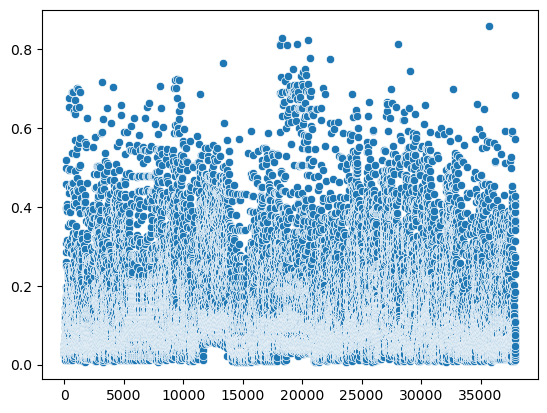

In [136]:
sns.scatterplot(data = sparse.data)

In [137]:
tfidf.vocabulary_['key']

3237

In [138]:
from sklearn.ensemble import RandomForestClassifier

X = sparse

X.min(), X.max()

(0.0, 0.8576555821864287)

In [139]:
from sklearn import preprocessing


# preprocessing encodage des données
encodage = preprocessing.LabelEncoder()
encodage.fit(df_texte.category_name)
df_texte["label_cat1"] = encodage.transform(df_texte.category_name)
# data.head(5)
df_texte.category_name.value_counts()

home furnishing       150
baby care             150
home decor            150
kitchen dining        150
beauty and            150
watches wrist         149
computers laptop       89
computers network      49
computers computer      6
computers tablet        3
computers storage       2
computers software      1
watches clocks          1
Name: category_name, dtype: int64

### Grid SearchCV

In [219]:
from sklearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

def create_pipeline_evaluate_model(index_fold, X_train, X_test, y_train, y_test,idx_train,idx_test):
    
        model = Pipeline([
                         ("classifier",SVC())
                         ])

        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        score = model.score(X_test,y_test)     
        print(f"Run {index_fold} : score = {round(score,2)} ")
        return (score)

In [215]:
from sklearn.model_selection import KFold
nb_model = 5
index_fold = 0
kf = KFold(n_splits=nb_model, shuffle=False)
average_score = 0

X = sparse
y = df_texte.label_cat1

kf = KFold(n_splits=nb_model)

for train_index, test_index in kf.split(X):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    score = create_pipeline_evaluate_model(index_fold, X_train, X_test, y_train, y_test,train_index,test_index)    
    average_score += score
    index_fold += 1
    
average_score = average_score / nb_model
print(average_score)

Run 0 : score = 0.67 
Run 1 : score = 0.62 
Run 2 : score = 0.74 
Run 3 : score = 0.75 
Run 4 : score = 0.65 
0.6866666666666666


In [216]:
pipe = Pipeline([('Tfidf', TfidfVectorizer(smooth_idf=False,norm='l2')),
                ("estimator",DecisionTreeClassifier(max_depth=None, min_samples_split=2,random_state=0))
                ])
pipe

Pipeline(steps=[('Tfidf', TfidfVectorizer(smooth_idf=False)),
                ('estimator', DecisionTreeClassifier(random_state=0))])

In [217]:
X = sparse
y = df_texte.label_cat1

param_grid = {'Tfidf':[TfidfVectorizer(smooth_idf=False,norm='l2'),TfidfVectorizer()],
              'estimator':[RandomForestClassifier(), 
                          ExtraTreesClassifier(), 
                          DecisionTreeClassifier(),
                          SVC(),
                          BaggingClassifier(),
                          KNeighborsClassifier(13),
                          LogisticRegression()
                          ]}

X = corpus_text

In [220]:
# test avec 6 classes 

from sklearn.model_selection import train_test_split, GridSearchCV


X = sparse
y = df_texte.label_cat1

param_grid = {'Tfidf':[TfidfVectorizer(smooth_idf=False,norm='l2'),TfidfVectorizer()],
              'estimator':[RandomForestClassifier(),
                           AdaBoostClassifier(),
                           GradientBoostingClassifier(),
                           ExtraTreesClassifier(),
                           DecisionTreeClassifier(),
                           SVC(),
                           BaggingClassifier(),
                           KNeighborsClassifier(13),
                           LogisticRegression()
                          ]}

X = corpus_text

grid = GridSearchCV(pipe,param_grid=param_grid, cv=10,return_train_score=True ,n_jobs=-1, verbose=1)

grid.fit(X,y)

grid_cv = pd.DataFrame(grid.cv_results_)

new_cols = [i for i in grid_cv.columns if 'split' not in i.lower()]

grid_cv.loc[:,new_cols].sort_values('mean_test_score', ascending=False)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


C:\Users\Dragomir\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Tfidf,param_estimator,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
17,2.105902,0.273357,0.015274,0.002105,TfidfVectorizer(),LogisticRegression(),"{'Tfidf': TfidfVectorizer(), 'estimator': Logi...",0.899048,0.062044,1,0.972593,0.001530
8,3.271599,0.462835,0.021108,0.008539,TfidfVectorizer(smooth_idf=False),LogisticRegression(),"{'Tfidf': TfidfVectorizer(smooth_idf=False), '...",0.898095,0.060542,2,0.974180,0.002074
14,1.258448,0.151454,0.076473,0.016460,TfidfVectorizer(),SVC(),"{'Tfidf': TfidfVectorizer(), 'estimator': SVC()}",0.884762,0.071327,3,0.994392,0.001257
5,1.369312,0.173174,0.088469,0.024143,TfidfVectorizer(smooth_idf=False),SVC(),"{'Tfidf': TfidfVectorizer(smooth_idf=False), '...",0.881905,0.068967,4,0.995238,0.001359
3,1.202521,0.084673,0.043466,0.010806,TfidfVectorizer(smooth_idf=False),ExtraTreesClassifier(),"{'Tfidf': TfidfVectorizer(smooth_idf=False), '...",0.869524,0.082374,5,1.000000,0.000000
12,1.209985,0.092727,0.042675,0.007470,TfidfVectorizer(),ExtraTreesClassifier(),"{'Tfidf': TfidfVectorizer(), 'estimator': Extr...",0.869524,0.074145,5,1.000000,0.000000
2,30.341237,1.838110,0.022154,0.003737,TfidfVectorizer(smooth_idf=False),GradientBoostingClassifier(),"{'Tfidf': TfidfVectorizer(smooth_idf=False), '...",0.858095,0.091295,7,1.000000,0.000000
11,31.244633,2.292336,0.019708,0.004168,TfidfVectorizer(),GradientBoostingClassifier(),"{'Tfidf': TfidfVectorizer(), 'estimator': Grad...",0.852381,0.088653,8,1.000000,0.000000
9,1.270946,0.170563,0.046527,0.006812,TfidfVectorizer(),RandomForestClassifier(),"{'Tfidf': TfidfVectorizer(), 'estimator': Rand...",0.840952,0.084225,9,1.000000,0.000000
0,1.078106,0.061535,0.045564,0.009949,TfidfVectorizer(smooth_idf=False),RandomForestClassifier(),"{'Tfidf': TfidfVectorizer(smooth_idf=False), '...",0.840000,0.089219,10,1.000000,0.000000


In [82]:


grid = GridSearchCV(pipe,param_grid=param_grid, cv=10,return_train_score=True ,n_jobs=-1, verbose=1)

In [83]:
grid.fit(X,y)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


C:\Users\Dragomir\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('Tfidf',
                                        TfidfVectorizer(smooth_idf=False)),
                                       ('estimator',
                                        DecisionTreeClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'Tfidf': [TfidfVectorizer(smooth_idf=False),
                                   TfidfVectorizer()],
                         'estimator': [RandomForestClassifier(),
                                       ExtraTreesClassifier(),
                                       DecisionTreeClassifier(), SVC(),
                                       BaggingClassifier(),
                                       KNeighborsClassifier(n_neighbors=13),
                                       LogisticRegression()]},
             return_train_score=True, verbose=1)

In [84]:
grid_cv = pd.DataFrame(grid.cv_results_)

new_cols = [i for i in grid_cv.columns if 'split' not in i.lower()]

grid_cv.loc[:,new_cols].sort_values('mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Tfidf,param_estimator,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
13,4.445476,0.297773,0.015054,0.005787,TfidfVectorizer(),LogisticRegression(),"{'Tfidf': TfidfVectorizer(), 'estimator': Logi...",0.899048,0.062044,1,0.972593,0.001530
6,4.636734,0.398972,0.022814,0.009414,TfidfVectorizer(smooth_idf=False),LogisticRegression(),"{'Tfidf': TfidfVectorizer(smooth_idf=False), '...",0.898095,0.060542,2,0.974180,0.002074
10,1.327339,0.210936,0.075818,0.011489,TfidfVectorizer(),SVC(),"{'Tfidf': TfidfVectorizer(), 'estimator': SVC()}",0.884762,0.071327,3,0.994392,0.001257
3,1.287736,0.112853,0.083028,0.013438,TfidfVectorizer(smooth_idf=False),SVC(),"{'Tfidf': TfidfVectorizer(smooth_idf=False), '...",0.881905,0.068967,4,0.995238,0.001359
1,1.251078,0.085693,0.042716,0.004368,TfidfVectorizer(smooth_idf=False),ExtraTreesClassifier(),"{'Tfidf': TfidfVectorizer(smooth_idf=False), '...",0.871429,0.070663,5,1.000000,0.000000
8,1.386359,0.255191,0.041313,0.004805,TfidfVectorizer(),ExtraTreesClassifier(),"{'Tfidf': TfidfVectorizer(), 'estimator': Extr...",0.871429,0.080728,5,1.000000,0.000000
4,1.073448,0.146865,0.030910,0.011232,TfidfVectorizer(smooth_idf=False),BaggingClassifier(),"{'Tfidf': TfidfVectorizer(smooth_idf=False), '...",0.843810,0.093139,7,0.994180,0.002515
7,1.384489,0.284906,0.056473,0.014819,TfidfVectorizer(),RandomForestClassifier(),"{'Tfidf': TfidfVectorizer(), 'estimator': Rand...",0.842857,0.083490,8,1.000000,0.000000
11,1.222627,0.283534,0.027965,0.012625,TfidfVectorizer(),BaggingClassifier(),"{'Tfidf': TfidfVectorizer(), 'estimator': Bagg...",0.834286,0.099267,9,0.994603,0.002434
0,1.065245,0.081034,0.045861,0.007004,TfidfVectorizer(smooth_idf=False),RandomForestClassifier(),"{'Tfidf': TfidfVectorizer(smooth_idf=False), '...",0.830476,0.091923,10,1.000000,0.000000


In [85]:
pipe = Pipeline([
                ("estimator",SVC(kernel = 'linear'))
                ])
pipe

Pipeline(steps=[('estimator', SVC(kernel='linear'))])

In [86]:
sparse

<1050x5940 sparse matrix of type '<class 'numpy.float64'>'
	with 37922 stored elements in Compressed Sparse Row format>

In [87]:
param_grid = {'kernel':['poly', 'rbf', 'sigmoid'],
              'gamma' : [0.0001, 0.001, 0.005, 0.01, 1, 10],
              'C' : [0.1,1,5,10,50,100]}
param_grid

X = sparse

from sklearn.model_selection import train_test_split, GridSearchCV


grid = GridSearchCV(SVC(),param_grid=param_grid, cv=10,return_train_score=True ,n_jobs=-1, verbose=1)

grid

GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 5, 10, 50, 100],
                         'gamma': [0.0001, 0.001, 0.005, 0.01, 1, 10],
                         'kernel': ['poly', 'rbf', 'sigmoid']},
             return_train_score=True, verbose=1)

In [88]:
grid.fit(X,y)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


C:\Users\Dragomir\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 5, 10, 50, 100],
                         'gamma': [0.0001, 0.001, 0.005, 0.01, 1, 10],
                         'kernel': ['poly', 'rbf', 'sigmoid']},
             return_train_score=True, verbose=1)

In [89]:
grid_cv = pd.DataFrame(grid.cv_results_)

new_cols = [i for i in grid_cv.columns if 'split' not in i.lower()]

grid_cv.loc[:,new_cols].sort_values('mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
100,1.055335,0.193628,0.076829,0.033770,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.908571,0.062626,1,0.999153,0.000635
50,0.945864,0.108462,0.044564,0.003360,5,1,sigmoid,"{'C': 5, 'gamma': 1, 'kernel': 'sigmoid'}",0.905714,0.061787,2,0.999894,0.000317
68,0.932582,0.178785,0.055460,0.014033,10,1,sigmoid,"{'C': 10, 'gamma': 1, 'kernel': 'sigmoid'}",0.904762,0.063030,3,1.000000,0.000000
86,0.920277,0.110245,0.053313,0.016996,50,1,sigmoid,"{'C': 50, 'gamma': 1, 'kernel': 'sigmoid'}",0.904762,0.061427,4,1.000000,0.000000
104,0.991317,0.134886,0.051211,0.011831,100,1,sigmoid,"{'C': 100, 'gamma': 1, 'kernel': 'sigmoid'}",0.904762,0.061427,4,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,1.283487,0.153074,0.079722,0.024061,50,10,rbf,"{'C': 50, 'gamma': 10, 'kernel': 'rbf'}",0.263810,0.063895,103,1.000000,0.000000
70,1.265444,0.142418,0.069469,0.007532,10,10,rbf,"{'C': 10, 'gamma': 10, 'kernel': 'rbf'}",0.263810,0.063895,103,1.000000,0.000000
106,1.278139,0.088999,0.070525,0.017687,100,10,rbf,"{'C': 100, 'gamma': 10, 'kernel': 'rbf'}",0.263810,0.063895,103,1.000000,0.000000
34,1.243444,0.174588,0.067766,0.008010,1,10,rbf,"{'C': 1, 'gamma': 10, 'kernel': 'rbf'}",0.243810,0.056697,107,1.000000,0.000000


In [90]:
sparse.toarray().shape

(1050, 5940)

In [91]:
svc = SVC(kernel = 'rbf',gamma = 0.1, C = 100)
X = sparse
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)


In [100]:
y_true = df_texte.label_cat1[y_test.index]

y_true

459      1
667      0
773      0
959      9
394      4
        ..
769     12
938      8
178     10
1014     0
405      1
Name: label_cat1, Length: 210, dtype: int32

In [93]:
dico = dict({"category_true" :y_true, "category_pred" : y_pred})

In [94]:
df_confu = pd.DataFrame(dico)
#df_confu.loc[df_confu.category_pred == 0]

,category_true,category_pred
667,0,0
784,0,0
220,0,0
629,0,0
599,0,0
893,9,0
622,0,0
1047,0,0
66,0,0
644,0,0


In [95]:
df_texte.category_name.unique()

array(['home furnishing', 'baby care', 'watches wrist', 'home decor',
       'kitchen dining', 'beauty and', 'computers network',
       'computers tablet', 'computers laptop', 'computers software',
       'computers computer', 'computers storage', 'watches clocks'],
      dtype=object)

In [96]:
pd.Series(y_pred).value_counts().sort_values()
idx = y_true.value_counts().index
idx_true = np.sort(idx)

In [97]:
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix = confusion_matrix(y_true, y_pred)


In [98]:
pd.Series(y_pred).value_counts().sort_values()

2      1
4      7
3     14
0     20
12    27
10    29
9     36
1     37
8     39
dtype: int64

In [99]:
pd.DataFrame(confusion_matrix, index=[idx_true],
                             columns=[idx_true]) 

,0,1,2,3,4,8,9,10,12
0,19,1,0,0,0,3,6,2,0
1,0,32,0,0,0,0,0,1,0
2,0,0,1,0,0,0,0,0,0
3,0,1,0,14,0,1,0,0,0
4,0,1,0,0,7,0,0,0,0
8,0,1,0,0,0,34,0,0,0
9,1,0,0,0,0,0,30,0,0
10,0,0,0,0,0,1,0,26,0
12,0,1,0,0,0,0,0,0,27


In [101]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.61      0.75        31
           1       0.86      0.97      0.91        33
           2       1.00      1.00      1.00         1
           3       1.00      0.88      0.93        16
           4       1.00      0.88      0.93         8
           8       0.87      0.97      0.92        35
           9       0.83      0.97      0.90        31
          10       0.90      0.96      0.93        27
          12       1.00      0.96      0.98        28

    accuracy                           0.90       210
   macro avg       0.94      0.91      0.92       210
weighted avg       0.91      0.90      0.90       210



In [81]:
from sklearn.manifold import TSNE

import time

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, init='random', random_state=6)

In [82]:
# mrtrice creuse des documents vectorisés avec la méthode td-idf

X = sparse

X.shape

(1050, 5940)

In [83]:
temps1 = time.time()

X_tsne = tsne.fit_transform(X)

duration1=time.time()-temps1

print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

C:\Users\Dragomir\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de T-SNE :             5.71 secondes


In [84]:
X_tsne.shape, tfidf.get_feature_names_out

((1050, 2),
 <bound method CountVectorizer.get_feature_names_out of TfidfVectorizer(input=['key features elegance polyester multicolor abstract '
                        'eyelet door curtain floral curtain elegance polyester '
                        'multicolor abstract eyelet door curtain 213 cm height '
                        'pack 2 price rs 899 curtain enhances look interiors '
                        'curtain made 100 high quality polyester fabric '
                        'features eyelet style stitch metal ring makes room '
                        'environment romantic loving curtain ant wrinkle anti '
                        's...
                        'watch boys men 10 online rs 950 india flipkart com '
                        'great discounts genuine products 30 day replacement '
                        'guarantee free shipping cash delivery', ...],
                 stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                             'ain', 'all',

In [85]:
df_texte

,product_name,product_category_tree,description,brand,category_name,label_cat1
0,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",Key Features of Elegance Polyester Multicolor ...,Elegance,home furnishing,9
1,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Specifications of Sathiyas Cotton Bath Towel (...,Sathiyas,baby care,0
2,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Key Features of Eurospa Cotton Terry Face Towe...,Eurospa,baby care,0
3,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of SANTOSH ROYAL FASHION Cotton P...,SANTOSH ROYAL FASHION,home furnishing,9
4,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of Jaipur Print Cotton Floral Kin...,Jaipur Print,home furnishing,9
...,...,...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Oren Empower Extra Large Self Adhesive Sticker...,Oren Empower,baby care,0
1046,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Wallmantra Large Vinyl Sticker Sticker (Pack o...,Wallmantra,baby care,0
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,Uberlyfe,baby care,0
1048,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Buy Wallmantra Medium Vinyl Sticker Sticker fo...,Wallmantra,baby care,0


In [86]:
df_texte.category_name.unique()

array(['home furnishing', 'baby care', 'watches wrist', 'home decor',
       'kitchen dining', 'beauty and', 'computers network',
       'computers tablet', 'computers laptop', 'computers software',
       'computers computer', 'computers storage', 'watches clocks'],
      dtype=object)

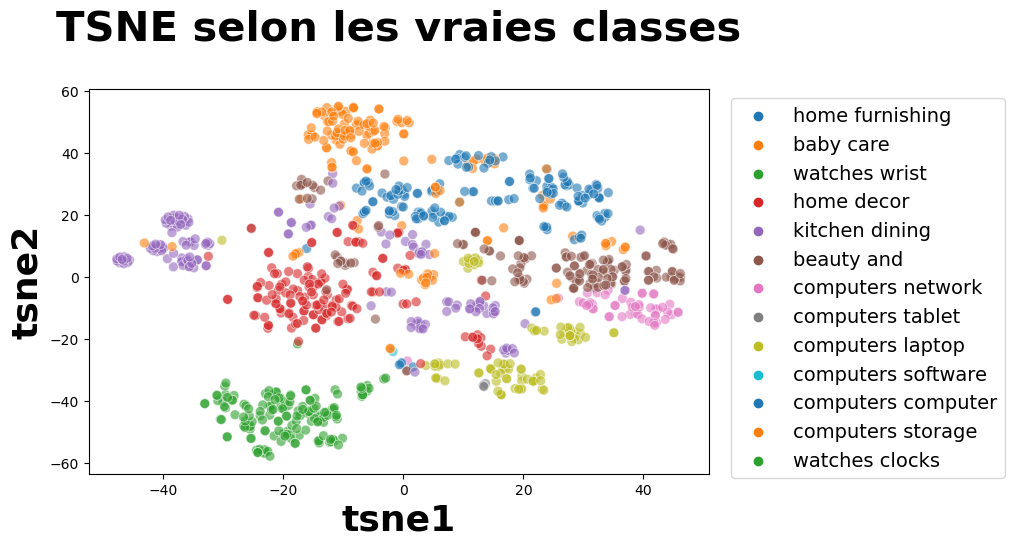

In [87]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = df_texte.category_name

plt.figure(figsize=(8,5))

sns.scatterplot(
    data=df_tsne,
    x="tsne1", 
    y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=13),
    s=50,
    alpha=0.6,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}, bbox_to_anchor=(1.02, 1)) 

plt.show()

In [109]:
sparse

<1050x5940 sparse matrix of type '<class 'numpy.float64'>'
	with 37922 stored elements in Compressed Sparse Row format>

In [88]:
#df['cluster'] = model.labels_

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


model = KMeans(n_clusters=12, init='k-means++')
model.fit(df_tsne[['tsne1','tsne2']])
df_tsne['cluster' ] = model.labels_

In [89]:
df_tsne

,tsne1,tsne2,class,cluster
0,5.128535,20.204002,home furnishing,1
1,12.172543,37.902252,baby care,11
2,10.758091,36.451622,baby care,11
3,4.653049,27.571945,home furnishing,11
4,4.752430,27.870857,home furnishing,11
...,...,...,...,...
1045,-0.481419,1.143384,baby care,2
1046,0.876551,0.842252,baby care,2
1047,3.623992,-2.550924,baby care,2
1048,3.905666,-0.172701,baby care,2


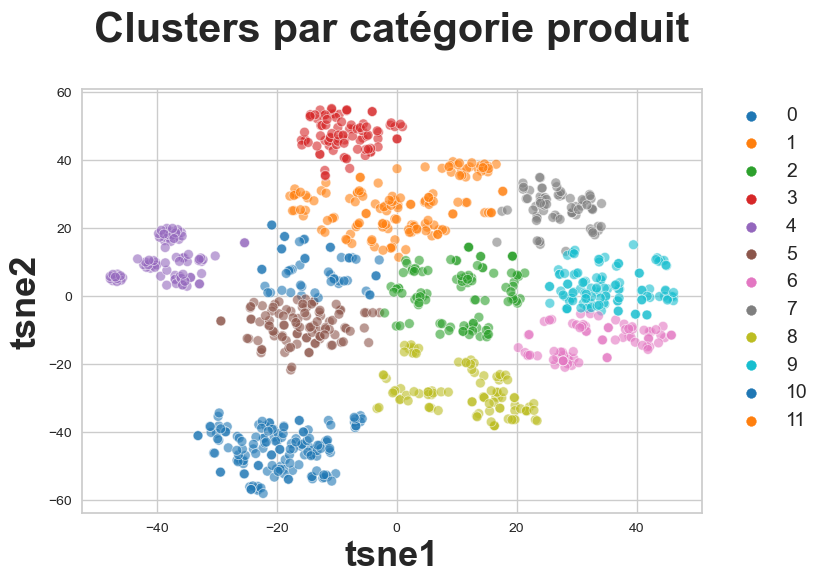

In [90]:
sns.scatterplot(
    data=df_tsne,
    x="tsne1", 
    y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=12),
    s=50,
    alpha=0.6,
    legend="brief")

plt.title('Clusters par catégorie produit', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}, bbox_to_anchor=(1.02, 1)) 

plt.show()

In [91]:
from sklearn.metrics import confusion_matrix, classification_report


y_true, y_pred = df_texte.label_cat1, df_tsne.cluster

confusion_matrix = confusion_matrix(y_true , y_pred)

confusion_matrix

array([[  0,   7,  13,  89,   2,   0,   2,   8,   0,   9,   4,  16,   0],
       [  0,  16,  31,   0,   1,   2,   0,   0,   2,  89,   9,   0,   0],
       [  0,   0,   0,   0,   0,   0,   2,   0,   4,   0,   0,   0,   0],
       [  0,   0,  12,   0,   1,   0,  25,   0,  51,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  43,   0,   1,   5,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   2,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   3,   0,   0,   0,   0],
       [  0,   5,  11,   0,   2,  95,   0,   0,  11,   0,  26,   0,   0],
       [  0,  54,   0,   0,   0,   0,   0,  61,   0,   4,   1,  30,   0],
       [  0,  11,  31,   0,  74,   2,   1,   0,  18,   3,  10,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0],
       [147,   0,   0,   0,   0,   1,   0,   0,   1,   0,   0,   0,   0]],
      dtype=int64)

In [114]:
pd.DataFrame(confusion_matrix, index=['label_true_0',
                                      'label_true_1',
                                      'label_true_2',
                                      'label_true_3',
                                      'label_true_4',
                                      'label_true_5',
                                      'label_true_6',
                                      'label_true_7',
                                      'label_true_8',
                                      'label_true_9',
                                      'label_true_10',
                                      'label_true_11',
                                      'label_true_12'],
                             columns=['label_pred_0',
                                      'label_pred_1',
                                      'label_pred_2',
                                      'label_pred_3',
                                      'label_pred_4',
                                      'label_pred_5',
                                      'label_pred_6',
                                      'label_pred_7',
                                      'label_pred_8',
                                      'label_pred_9',
                                      'label_pred_10',
                                      'label_pred_11',
                                      'label_pred_12']) 

,label_pred_0,label_pred_1,label_pred_2,label_pred_3,label_pred_4,label_pred_5,label_pred_6,label_pred_7,label_pred_8,label_pred_9,label_pred_10,label_pred_11,label_pred_12
label_true_0,10,4,0,16,91,0,5,2,6,10,4,2,0
label_true_1,89,10,0,0,0,2,16,1,0,1,31,0,0
label_true_2,0,0,0,0,0,4,0,0,0,0,0,2,0
label_true_3,0,0,0,0,0,51,0,1,0,0,12,25,0
label_true_4,5,0,0,0,0,1,0,0,0,0,0,43,0
label_true_5,0,0,0,0,0,1,0,0,0,0,0,0,0
label_true_6,0,0,0,0,0,2,0,0,0,0,0,0,0
label_true_7,0,0,0,0,0,3,0,0,0,0,0,0,0
label_true_8,0,104,0,0,0,11,14,2,0,17,2,0,0
label_true_9,4,1,0,30,0,0,48,0,61,0,6,0,0


In [115]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.09      0.07      0.08       150
           1       0.08      0.07      0.07       150
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00        89
           4       0.00      0.00      0.00        49
           5       0.01      1.00      0.02         1
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00       150
           9       0.00      0.00      0.00       150
          10       0.14      0.06      0.08       150
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00       149

    accuracy                           0.03      1050
   macro avg       0.03      0.09      0.02      1050
weighted avg       0.04      0.03      0.03      1050



C:\Users\Dragomir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dragomir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dragomir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [116]:
# récupère unique les données textuelles des produits

corpus_text[0:2]

['key features elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain 213 cm height pack 2 price rs 899 curtain enhances look interiors curtain made 100 high quality polyester fabric features eyelet style stitch metal ring makes room environment romantic loving curtain ant wrinkle anti shrinkage elegant apparance give home bright modernistic appeal designs surreal attention sure steal hearts contemporary eyelet valance curtains slide smoothly draw apart first thing morning welcome bright sun rays want wish good morning whole world draw close evening create special moments joyous beauty given soothing prints bring home elegant curtain softly filters light room get right amount sunlight specifications elegance polyester multicolor abstract eyelet door curtain 213 cm height pack 2 general brand elegance designed door type eyelet model name abstract polyester door curtain set 2 model id duster25 color multicolor 